<h2 align='center'> MID Deep Learning </h2>
<br>
<hr>
<br>

Anggota Kelompok: 

*   Aso Ahmad Amin Rais - H071191037
*   Bayu Ajid - H071191036
*   Muh. Yusuf Syam - H071191044




Soal: Technical Report dan reproduksi kode <a href='https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.ipynb'>dari sini<a/>

<a href="https://colab.research.google.com/drive/172fv0RSRoVc5ZBSQ6rF2HF4FOcjrBz1p?usp=sharing" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

Dalam technical report ini, kita akan mengimplementasikan, membahas, dan membandingkan varian arsitektur CNN modern. Ada banyak arsitektur yang berbeda telah diusulkan selama beberapa tahun terakhir. Beberapa yang paling berdampak, dan masih relevan hingga saat ini seperti [GoogleNet / Arsitektur Inception](https://arxiv.org/abs/1409.4842) , Pemenang ILSVRC 2014, [ResNet](https://arxiv.org/abs/1512.03385), Pemenang ILSVRC 2015 dan [DenseNet](https://arxiv.org/abs/1608.06993), Penghargaan best paper CVPR 2017. Ketiga arsitektur tersebut menjadi state-of-the-art saat diusulkan dan menjadi fondasi dari sebagian besar arsitektur-arsitektur CNN saat ini. Oleh karena itu, penting untuk memahami arsitektur ini secara detail dan mempelajari cara mengimplementasikannya.

Pertama-tama, kita mengimport library yang dibutuhkan

In [1]:
## Standard libraries
import os
import numpy as np 
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

Selanjutnya kita akan membuat variabel path, yaitu `DATASET_PATH` sebagai path untuk menyimpan dataset dan `CHECKPOINT_PATH` sebagai path untuk menyimpan model checkpoint. 

Kita juga mendefinisikan fungsi `set_seed`  untuk menyetel seed pada semua library yang mungkin berinteraksi dengan kode (seperti pytorch, numpy, random). Hal ini memungkinkan agar proses training dapat direproduksi karena angka random yang dihasilkan seed yang sama akan selalu sama terlepas dari kapan dan di mana prosesnya terjadi.

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Kita telah memiliki pre-trained model dan tensorboard sebelumnya, jadi kita akan mendownload file pre-trained model dan tensorboard terlebih dahulu.

In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

Dataset yang akan digunakan untuk membandingkan arsitektur GoogLeNet, ResNet dan DenseNet yaitu dataset CIFAR10.

In [39]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)

Files already downloaded and verified


**Data Preprocessing**

Pertama-tama kita akan menghitung rata-rata dan simpangan baku dari data, yang nantinya akan kita gunakan untuk melakukan normalisasi.

In [40]:
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))

print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


Kita juga akan melakukan augmentasi data, ini akan mengurangi risiko overfitting dan membantu arsitektur CNN lebih general. Secara khusus, kita akan menerapkan dua augmentasi acak.

1. Membalik setiap gambar secara horizontal dengan peluang 50% (`transforms.RandomHorizontalFlip`)

2. Me-rescale gambar dalam rentang kecil, lalu melakukan crop `transforms.RandomResizedCrop`. Ini membuat nilai piksel aktual pada gambar berubah sementara konten atau semantik keseluruhan gambar tetap sama.

Kita akan secara acak membagi data latih menjadi data latih dan validasi. Data validasi akan digunakan untuk menentukan *early stopping*. Setelah menyelesaikan pelatihan, barulah kita menguji model pada data uji CIFAR.

In [5]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Untuk memverifikasi bahwa data benar-benar ternormalisasi, kita dapat melakukan print pada mean dan standar deviasi dari satu batch tunggal. Rata-rata harus mendekati 0 dan simpangan baku mendekati 1 untuk setiap channel.

In [6]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


Terakhir, mari kita visualisasikan beberapa gambar dari data latih, dan bagaimana tampilannya setelah augmentasi data acak.

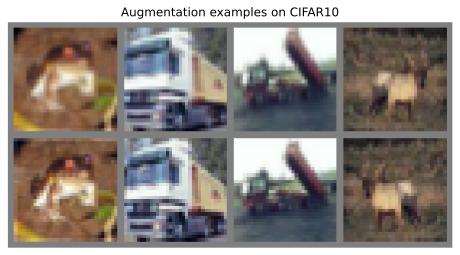

In [7]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## PyTorch Lightning

Kita akan menggunakan [PyTorch Lightning](https://www.pytorchlightning.ai/) untuk proses *train* dan *evaluate*. PyTorch Lightning adalah wrapper framework untuk pytorch yang menyederhanakan kode yang diperlukan untuk melatih, mengevaluasi, dan menguji model. Pytorch Lightning juga menangani logging ke [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), toolkit visualisasi untuk eksperimen Machine Learning serta memudahkan dalam penggunaan callback, seperti model checkpoint.

In [8]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

PyTorch Lightning memiliki fungsi-fungsi high level agar kita tidak perlu lagi menulis kode boilerplate (berulang) dan membuat kita lebih fokus membangun model. Misalnya untuk menyetel seed.

In [9]:
# Setting the seed
pl.seed_everything(42)

Global seed set to 42


42

Di PyTorch Lightning, model didefinisikan sebagai class turunan dari  `pl.LightningModule` (yang mewarisi lagi dari `torch.nn.Module`).  `pl.LightningModule` mengatur kode kita menjadi 5 bagian utama:

1. Inisialisasi (`__init__`), di mana kita menginisialisasikan dan membuat semua parameter/model yang diperlukan.
2. Optimizers (`configure_optimizers`) tempat kita membuat optimizers, penjadwalan learning rate, dll.
3. Train Loop (`training_step`) di mana kita hanya perlu mendefinisikan perhitungan loss untuk satu batch (loop optimizer.zero_grad(), loss.backward() dan optimizer.step(), serta setiap logging/ operasi penyimpanan, dilakukan di latar belakang).
4. Validation Loop (`validation_step`) sama seperti Train Loop, kita hanya perlu mendefinisikan perhitungan loss untuk satu batch validasi.
5. Test loop (`test_step`) di mana kita hanya perlu mendefinisikan perhitungan loss untuk satu batch tes.

Berikut merupakan contoh pembuatan model Pytorch Lightning

In [10]:
class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

Kita dapat melihat, bahwa kode terorganisir dan jelas untuk dibaca, ini akan membantu jika orang lain mencoba memahami kode yang dibuat. Kelas atau modul Lightning inilah nantinya yang digunakan sebagai model dasar, yang mana salah satu hyperparameternya yaitu model, yang nantinya akan diisi berdasarkan model CNN yang akan dibandingkan (GoogLeNet, ResNet dan DenseNet).



Bagian penting lainnya dari PyTorch Lightning adalah konsep callback. Callback adalah fungsi khusus yang biasanya dipanggil setelah menyelesaikan periode pelatihan. Misalnya, kita akan menggunakan dua callback yang telah ditentukan sebelumnya: `LearningRateMonitor` dan `ModelCheckpoint`. 
1. Callback `LearningRateMonitor` menambahkan learning rate saat ini ke Logs TensorBoard , yang membantu memverifikasi bahwa `LearningRateScheduler` berfungsi dengan benar. 
2. Callback `ModelCheckpoint` memungkinkan kita untuk menyimpan model pada epoch tertentu atau sesuai jadwal yang telah disetel sebelumnya.

In [11]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

Untuk memungkinkan menjalankan beberapa model CNN yang berbeda dengan modul Lightning yang sama, kita mendefinisikan fungsi `create_model` di bawah ini yang memetakan nama model ke kelas model. Pada tahap ini, dictionary `model_dict` kosong, tetapi kita akan mengisinya nanti.

In [12]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Demikian pula, untuk menggunakan fungsi aktivasi sebagai hyperparameter lain dalam model kita, kita mendefinisikan dict "name to function" di bawah ini:

In [13]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

Jika kita meneruskan kelas atau objek secara langsung sebagai argumen ke modul Lightning, kita tidak dapat memanfaatkan penyimpanan dan pemuatan hyperparameter PyTorch Lightning secara otomatis.

Selain modul Lightning, modul terpenting kedua di PyTorch Lightning adalah `Trainer`. `Trainer` bertanggung jawab untuk melakukan proses training (mengeksekusi fungsi training step pada modul Lightning). Sama seperti modul Lightning, `Trainer` ini bersifat fleksibel, artinya kita dapat memodifikasi bagian-bagian dari proses training yang dilakukan oleh `Trainer`. Bagian terpenting yang akan digunakan yaitu:

* `trainer.fit`: Mengambil modul lightning, set data latih, dan set data validasi (opsional) sebagai input. Fungsi ini melatih modul yang diberikan pada dataset latih dengan validasi sesekali (default sekali per epoch, dapat diubah)
* `trainer.test`: Mengambil model dan set data uji sebagai input. Fungsi ini mengembalikan metrik pengujian pada dataset.

Untuk pelatihan dan pengujian, kita tidak perlu khawatir tentang hal-hal seperti menyetel model ke mode eval (`model.eval()`) karena ini semua dilakukan secara otomatis. Lihat di bawah bagaimana kita mendefinisikan fungsi pelatihan untuk model:

In [14]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         progress_bar_refresh_rate=1)                                                        # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

Terakhir, kita dapat fokus pada arsitektur CNN yang ingin kita terapkan: GoogLeNet, ResNet, dan DenseNet.

### 1. GoogLeNet / Inception

[GoogleNet](https://arxiv.org/abs/1409.4842), yang diusulkan pada tahun 2014, memenangkan Tantangan ImageNet karena penggunaan modul Inception. 

Blok Inception menerapkan empat blok konvolusi secara terpisah pada satu blok yang sama: konvolusi 1x1, 3x3, dan 5x5, dan operasi max poolin. Blok Inception keseluruhan terlihat seperti di bawah ini (kredit angka - [Szegedy et al.](https://arxiv.org/abs/1409.4842)):

inception_block.svg

Konvolusi 1x1 tambahan sebelum konvolusi 3x3 dan 5x5 digunakan untuk reduksi dimensi. Ini sangat penting karena feature map dari semua cabang digabungkan nantinya, dan kita tidak ingin ada ledakan ukuran fitur. Karena komputasi konvolusi 5x5 lebih mahal 25 kali daripada konvolusi 1x1, kita dapat menghemat banyak komputasi dan parameter dengan mengurangi dimensi sebelum konvolusi besar selanjutnya.

Sekarang kita dapat mencoba mengimplementasikan Inception Block sendiri:

In [15]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        
        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

Arsitektur GoogleNet terdiri dari beberapa blok Inception dengan max pooling sesekali untuk mengurangi tinggi dan lebar feature map. GoogleNet asli dirancang untuk ukuran gambar ImageNet (224x224 piksel) dan memiliki hampir 7 juta parameter. Saat kita melakujan pelatihan dengan data CIFAR10 dengan ukuran gambar 32x32, kita tidak memerlukan arsitektur yang berat. Jumlah channel untuk reduksi dimensi dan keluaran per filter (1x1, 3x3, 5x5, dan max pooling) perlu ditentukan secara manual dan dapat diubah. Umumnya filter terbanyak untuk konvolusi adalah 3x3, karena filter tersebut cukup baik mempertimbangkan parameter yang dibutuhkan hanya sekitar sepertiga dari parameter konvolusi 5x5.

In [16]:
class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Sekarang, kita dapat mengintegrasikan model kita ke dict model yang kita definisikan di atas:

In [17]:
model_dict["GoogleNet"] = GoogleNet

Pelatihan model ditangani oleh PyTorch Lightning, dan kita hanya perlu memanggil fungsi `train_model` perintah untuk memulai pelatihan. Kita melakukan pelatihan model pada hampir 200 epochs, yang memakan waktu sekitar satu jam pada GPU default Lisa (GTX1080Ti). Direkomendasikan menggunakan pre-trained model.

**Train Model**

In [18]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                 model_hparams={"num_classes": 10, 
                                                                "act_fn_name": "relu"}, 
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../saved_models/tutorial5/GoogleNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/GoogleNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Kita akan membandingkan hasilnya nanti di akhir notebook, tapi kita sudah bisa melihat hasil akurasi tes dan validasi:

In [19]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8970000147819519, 'val': 0.9039999842643738}


**Tensorboard log**

Salah satu fitur krusial PyTorch Lightning adalah logging otomatis ke TensorBoard. Kita dapat melihat TensorBoard yang telah dibuat oleh PyTorch Lightning saat melatih GoogleNet. Berikut cara menggunakan TensorBoard:

In [20]:
# Load tensorboard extension
%load_ext tensorboard

In [46]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir ../saved_models/tensorboards/GoogleNet/

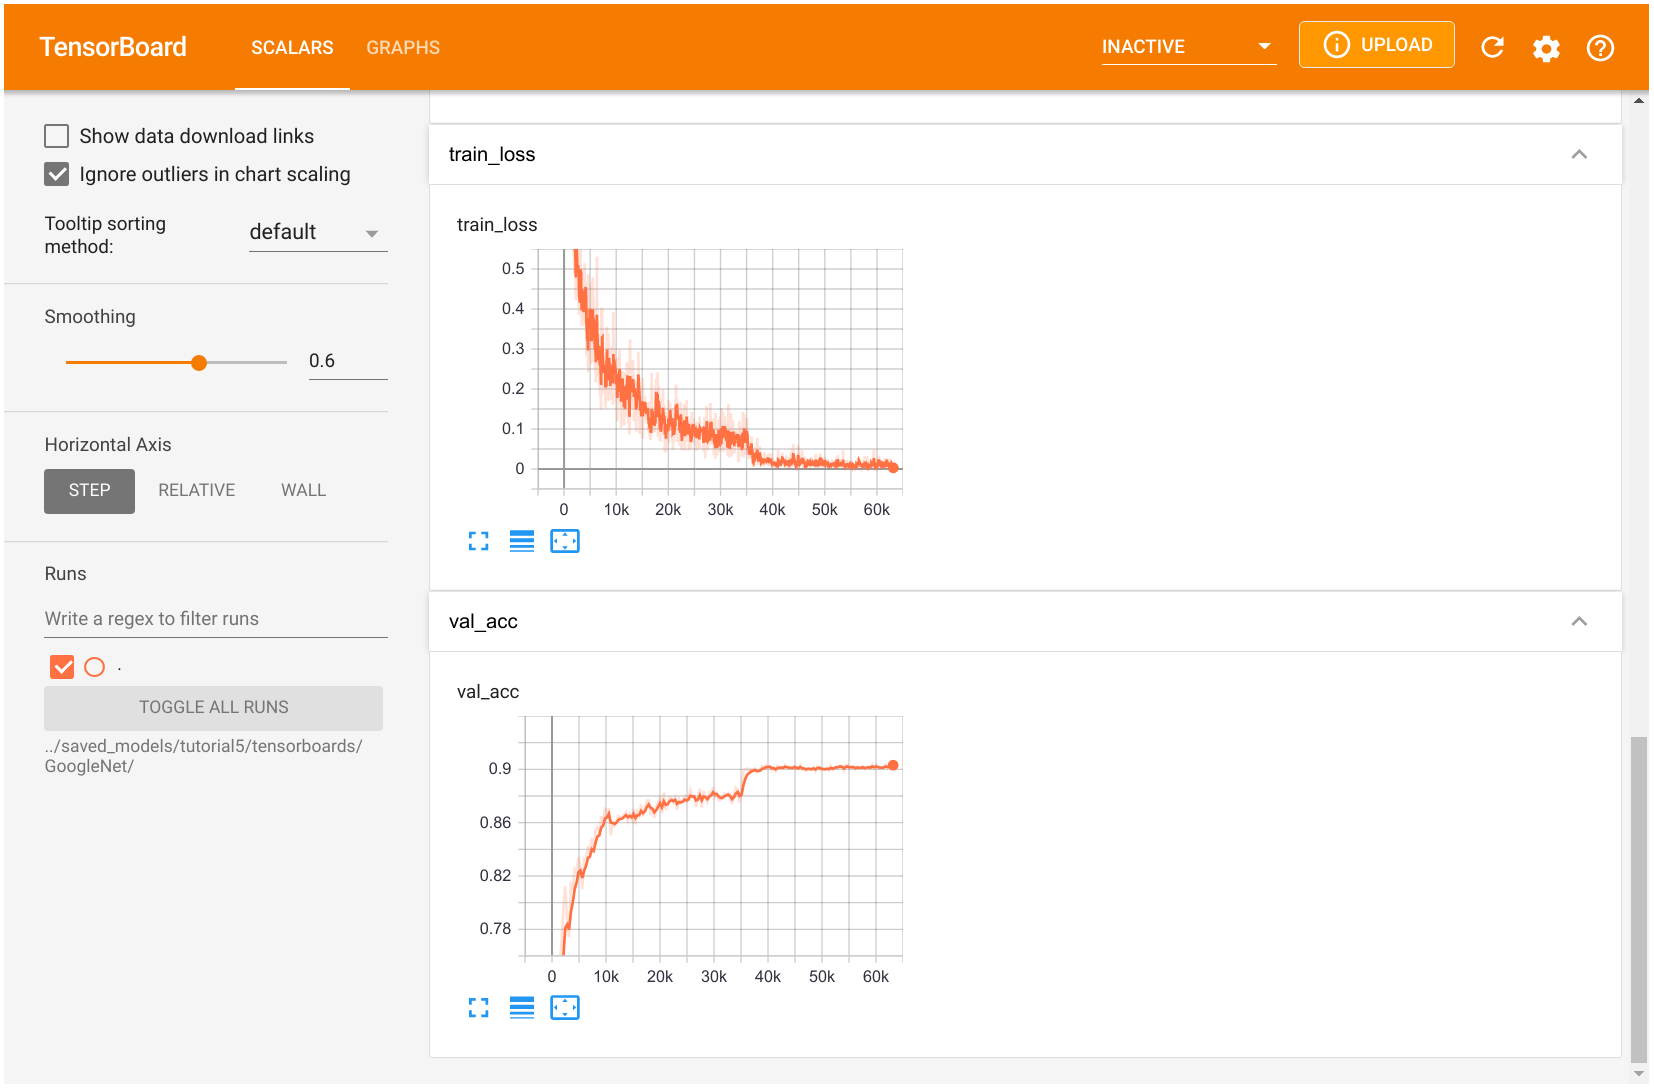

### 2. ResNet

Paper  [ResNet](https://arxiv.org/abs/1512.03385) merupakan salah satu [Paper AI yang paling banyak dikutip](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), dan telah menjadi dasar untuk neural network dengan lebih dari 1.000 layer. Terlepas dari kesederhanaannya, ide koneksi residual sangat efektif karena mendukung propagasi gradien yang stabil melalui jaringan neural network. Alih-alih memodelkan $x_{l+1}=F(x_{l})$, kita memodelkan $x_{l+1}=x_{l}+F(x_{l})$ di mana $F$ adalah non -pemetaan linier (biasanya urutan modul NN seperti konvolusi, fungsi aktivasi, dan normalisasi). Jika kita melakukan backpropagation pada koneksi residual tersebut, kita memperoleh:

$$\frac{\partial x_{l+1}}{\partial x_{l}} = \mathbf{I} + \frac{\partial F(x_{l})}{\partial x_{l}} $$

Bias terhadap matriks identitas menjamin propagasi gradien yang stabil menjadi kurang dipengaruhi oleh $F$ itu sendiri. Ada banyak varian ResNet yang diusulkan, yang sebagian besar menyangkut fungsi $F$, atau operasi yang diterapkan pada penjumlahan. Dalam technical report ini, kita mengimplementasikan dua di antaranya: blok ResNet asli, dan [blok ResNet Pra-Aktivasi](https://arxiv.org/abs/1603.05027). Kami membandingkan blok-blok di bawah secara visual (kredit angka - [He et al.](https://arxiv.org/abs/1603.05027)):

resnet_block.svg

Blok ResNet asli menerapkan fungsi aktivasi non-linear, biasanya ReLU, setelah skip connection. Sebaliknya, blok ResNet pra-aktivasi menerapkan non-linearitas di awal $F$. Keduanya memiliki kelebihan dan kekurangan masing-masing. Namun, untuk neural network yang sangat dalam, pra-aktivasi ResNet telah menunjukkan kinerja yang lebih baik karena aliran gradien dijamin memiliki matriks identitas seperti yang dihitung di atas, dan tidak dirugikan oleh aktivasi non-linier yang diterapkan padanya. Sebagai perbandingan, di notebook ini, kita menerapkan kedua jenis ResNet sebagai neural network yang dangkal.

Mari kita mulai dengan blok ResNet asli. Visualisasi di atas sudah menunjukkan layer apa saja yang termasuk dalam $F$. Satu kasus khusus yang harus kita tangani adalah ketika kita ingin mengurangi dimensi gambar dalam hal lebar dan tinggi. Blok dasar ResNet memerlukan $F(x_{l})$ memiliki bentuk yang sama dengan $x_{l}$. Jadi, kita juga perlu mengubah dimensi $x_{l}$ sebelum menambahkan ke $F(x_{l})$. Implementasi asli menggunakan pemetaan identitas dengan stride 2 dan menambahkan dimensi fitur tambahan dengan 0. Namun, implementasi yang lebih umum adalah menggunakan konvolusi 1x1 dengan stride 2 karena memungkinkan kita untuk mengubah dimensi fitur dan tetap efisien dalam parameter dan biaya komputasi. Kode untuk blok ResNet relatif sederhana, dan ditunjukkan di bawah ini:

In [22]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

Blok kedua yang kita terapkan adalah blok ResNet pra-aktivasi. Untuk ini, kita harus mengubah urutan layer di `self.net`, dan tidak menerapkan fungsi aktivasi pada output. Selain itu, operasi downsampling harus menerapkan non-linearitas serta input, $x_l$, belum diproses oleh non-linearitas. Oleh karena itu, blok terlihat sebagai berikut:

In [23]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        
        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

Sama halnya dengan pemilihan model, kita mendefinisikan dict untuk membuat pemetaan dari kelas string ke blok ResNet. Kita akan menggunakan nama string sebagai hyperparameter dalam model kita untuk memilih di antara blok ResNet.

In [24]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

Selanjutnya arsitektur Resnet, arsitektur ResNet keseluruhan terdiri dari penumpukan beberapa blok ResNet, di mana beberapa di antaranya melakukan downsampling input. Ketika berbicara tentang blok ResNet di seluruh jaringan, kita biasanya mengelompokkannya berdasarkan bentuk keluaran yang sama. Oleh karena itu, jika kita mengatakan bahwa ResNet memiliki blok `[3,3,3]`, itu berarti kita memiliki 3 kali grup yang terdiri dari 3 blok ResNet, di mana subsampling berlangsung di blok keempat dan ketujuh. ResNet dengan blok `[3,3,3]` di CIFAR10 divisualisasikan di bawah ini.

resnet_notation.svg

Tiga grup beroperasi pada resolusi $32\times32$, $16\times16$ dan $8\times8$ masing-masing. Blok berwarna oranye menunjukkan blok ResNet dengan downsampling. Notasi yang sama digunakan oleh banyak implementasi lain seperti di [library torchvision](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html#resnet18) dari PyTorch. Dengan demikian, kode kita terlihat sebagai berikut:

In [47]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        """
        Inputs: 
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - Name of the activation function to use, looked up in "act_fn_by_name"
            block_name - Name of the ResNet block, looked up in "resnet_blocks_by_name"
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name],
                                       block_class=resnet_blocks_by_name[block_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        if self.hparams.block_class == PreActResNetBlock: # => Don't apply non-linearity on output
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn()
            )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Kita juga perlu menambahkan kelas ResNet ke dict model:

In [26]:
model_dict["ResNet"] = ResNet

Akhirnya, kita dapat melatih model ResNet kami. Satu perbedaan pada pelatihan GoogleNet adalah bahwa kami secara eksplisit menggunakan SGD dengan Momentum sebagai optimizer, bukan Adam. Adam biasanya menghasilkan akurasi yang sedikit lebih buruk pada ResNet yang sederhana dan dangkal. Tidak 100% jelas mengapa kinerja Adam lebih buruk dalam konteks ini, tetapi satu penjelasan yang mungkin terkait dengan loss surface dari ResNet. ResNet telah terbukti menghasilkan loss surface yang lebih halus daripada jaringan tanpa skip connections (lihat [Li et al., 2018](https://arxiv.org/pdf/1712.09913.pdf) untuk detailnya). Visualisasi yang mungkin dari loss surface dengan/tanpa skip connection seperti di bawah (kredit gambar - [Li et al.](https://arxiv.org/pdf/1712.09913.pdf)):

resnet_loss_surface.svg

Sumbu $x$ dan $y$ menunjukkan proyeksi ruang parameter, dan sumbu $z$ menunjukkan nilai loss yang dicapai oleh nilai parameter yang berbeda. Pada permukaan halus seperti yang ada di sebelah kanan, kita mungkin tidak memerlukan tingkat pembelajaran adaptif seperti yang disediakan Adam. Sebaliknya, Adam bisa terjebak di local optima sementara SGD menemukan minima yang lebih luas yang cenderung menggeneralisasi lebih baik.

**Train Model**

In [27]:
resnet_model, resnet_results = train_model(model_name="ResNet", 
                                           model_hparams={"num_classes": 10,
                                                          "c_hidden": [16,32,64],
                                                          "num_blocks": [3,3,3],
                                                          "act_fn_name": "relu"}, 
                                           optimizer_name="SGD",
                                           optimizer_hparams={"lr": 0.1,
                                                              "momentum": 0.9,
                                                              "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../saved_models/tutorial5/ResNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/ResNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Mari kita juga melatih ResNet pra-aktivasi sebagai perbandingan:

In [28]:
resnetpreact_model, resnetpreact_results = train_model(model_name="ResNet", 
                                                       model_hparams={"num_classes": 10,
                                                                      "c_hidden": [16,32,64],
                                                                      "num_blocks": [3,3,3],
                                                                      "act_fn_name": "relu",
                                                                      "block_name": "PreActResNetBlock"}, 
                                                       optimizer_name="SGD",
                                                       optimizer_hparams={"lr": 0.1,
                                                                          "momentum": 0.9,
                                                                          "weight_decay": 1e-4},
                                                       save_name="ResNetPreAct")

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../saved_models/tutorial5/ResNetPreAct/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/ResNetPreAct.ckpt, loading...


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

**Tensorboard log**

Serupa dengan model GoogleNet, kita juga memiliki log TensorBoard untuk model ResNet. Kita bisa membukanya di bawah.

In [48]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tensorboards/ResNet/

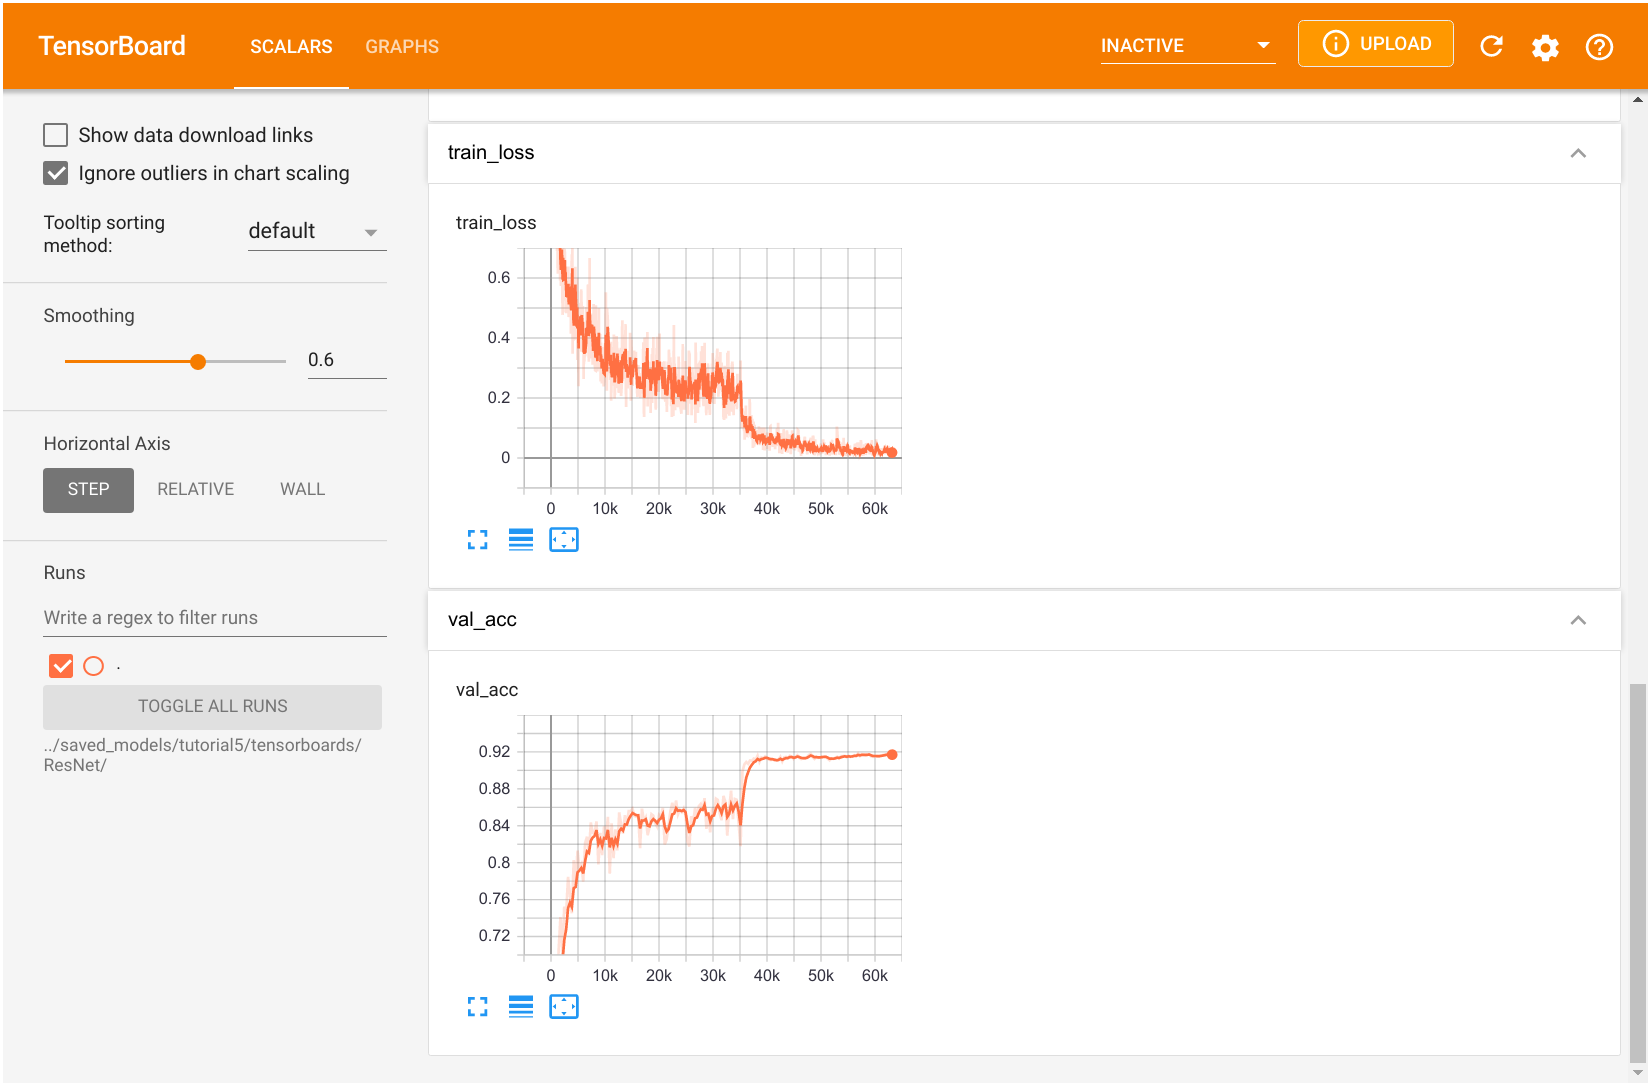

### 3. DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993) adalah arsitektur lain untuk  jaringan saraf yang sangat dalam dan mengambil perspektif yang sedikit berbeda tentang koneksi residual. Alih-alih memodelkan perbedaan antar layer, DenseNet menganggap koneksi residual sebagai cara yang mungkin untuk menggunakan kembali fitur di seluruh layer, menghilangkan kebutuhan apa pun untuk mempelajari feature map yang berlebihan. Jika kita masuk lebih dalam ke jaringan, model mempelajari fitur abstrak untuk mengenali pola. Namun, beberapa pola kompleks terdiri dari kombinasi fitur abstrak (misalnya tangan, wajah, dll.), dan fitur low-level (misalnya tepi, warna dasar, dll.). Untuk menemukan fitur low-level ini di layer yang dalam, CNN standar harus belajar menyalin feature map tersebut, yang membuang banyak kompleksitas parameter. DenseNet menyediakan cara yang efisien untuk menggunakan kembali fitur dengan membuat setiap konvolusi bergantung pada semua fitur input sebelumnya, tetapi hanya menambahkan sedikit filter ke dalamnya. Lihat gambar di bawah untuk ilustrasi (kredit gambar - [Hu et al.](https://arxiv.org/abs/1608.06993)):

densenet_block.svg

Layer terakhir, yang disebut Transition layer, bertanggung jawab untuk mengurangi dimensi feature map dalam tinggi, lebar, dan ukuran channel. Meskipun secara teknis merusak identitas backpropagation, hanya ada beberapa di jaringan sehingga tidak banyak mempengaruhi aliran gradien.

Kita membagi implementasi layer di DenseNet menjadi tiga bagian: `DenseLayer`, dan `DenseBlock`, dan `TransitionLayer`. Modul `DenseLayer` mengimplementasikan satu layer di dalam blok dense. Ini menerapkan konvolusi 1x1 untuk pengurangan dimensi dengan konvolusi 3x3 berikutnya. Channel output digabungkan ke aslinya sebelum di-return. Kita menerapkan Batc Normalizatiob sebagai layer pertama dari setiap blok. Ini memungkinkan aktivasi yang sedikit berbeda untuk fitur yang sama ke layer yang berbeda, tergantung pada apa yang dibutuhkan. Secara keseluruhan, Kita dapat menerapkannya sebagai berikut:

In [30]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

Modul `DenseBlock` merangkum beberapa dense layer yang diterapkan secara berurutan. Setiap dense layer mengambil input asli sebagai input yang digabungkan dengan feature map semua layer sebelumnya:

In [31]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

Terakhir, `TransitionLayer` mengambil input sebagai output akhir dari dense block dan mengurangi dimensi channel-nya menggunakan konvolusi 1x1. Untuk mengurangi dimensi tinggi dan lebar, kita mengambil pendekatan yang sedikit berbeda daripada di ResNet dan menerapkan average pooling dengan ukuran kernel 2 dan stride 2. Ini karena kita tidak memiliki koneksi tambahan ke output yang membutuhkan 2x2 alih-alih nilai tunggal. Selain itu, parameter ini lebih efisien daripada menggunakan konvolusi 3x3 dengan stride 2. Dengan demikian, Trainsition layer diimplementasikan sebagai berikut:

In [32]:
class TransitionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )
        
    def forward(self, x):
        return self.transition(x)

Sekarang kita dapat menggabungkan semuanya dan membuat jarinan DenseNet. Untuk menentukan jumlah layer, kita menggunakan notasi/cara yang sama seperti di ResNet dan meneruskan list berisi integer yang mewakili jumlah layer per blok. Setelah setiap dense block kecuali yang terakhir, kita menerapkan Transition layer untuk mengurangi dimensi sebesar 2.

In [33]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        
        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Mari tambahkan juga DenseNet ke dict model kita:

In [34]:
model_dict["DenseNet"] = DenseNet

Terakhir, kita melatih model DenseNet. Berbeda dengan ResNet, DenseNet tidak menunjukkan masalah apa pun dengan Adam, dan oleh karena itu kita menggunakan Adam sebagai optimizers. Hyperparameter lainnya disetel sama dengan hyperparameter dari model GoogLeNet dan ResNet. Umumnya, ketika merancang jaringan yang sangat dalam, parameter DenseNet lebih efisien/sedikit daripada ResNet dan tetap mencapai performa yang serupa atau dalam beberapa kasus, bahkan lebih baik.

**Train Model**

In [35]:
densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                               model_hparams={"num_classes": 10,
                                                              "num_layers": [6,6,6,6],
                                                              "bn_size": 2,
                                                              "growth_rate": 16,
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="Adam",
                                               optimizer_hparams={"lr": 1e-3,
                                                                  "weight_decay": 1e-4})

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../saved_models/tutorial5/DenseNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/DenseNet.ckpt, loading...


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

**Tensorboard log**

In [49]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH! Feel free to change "ResNet" to "ResNetPreAct"
%tensorboard --logdir ../saved_models/tensorboards/DenseNet/

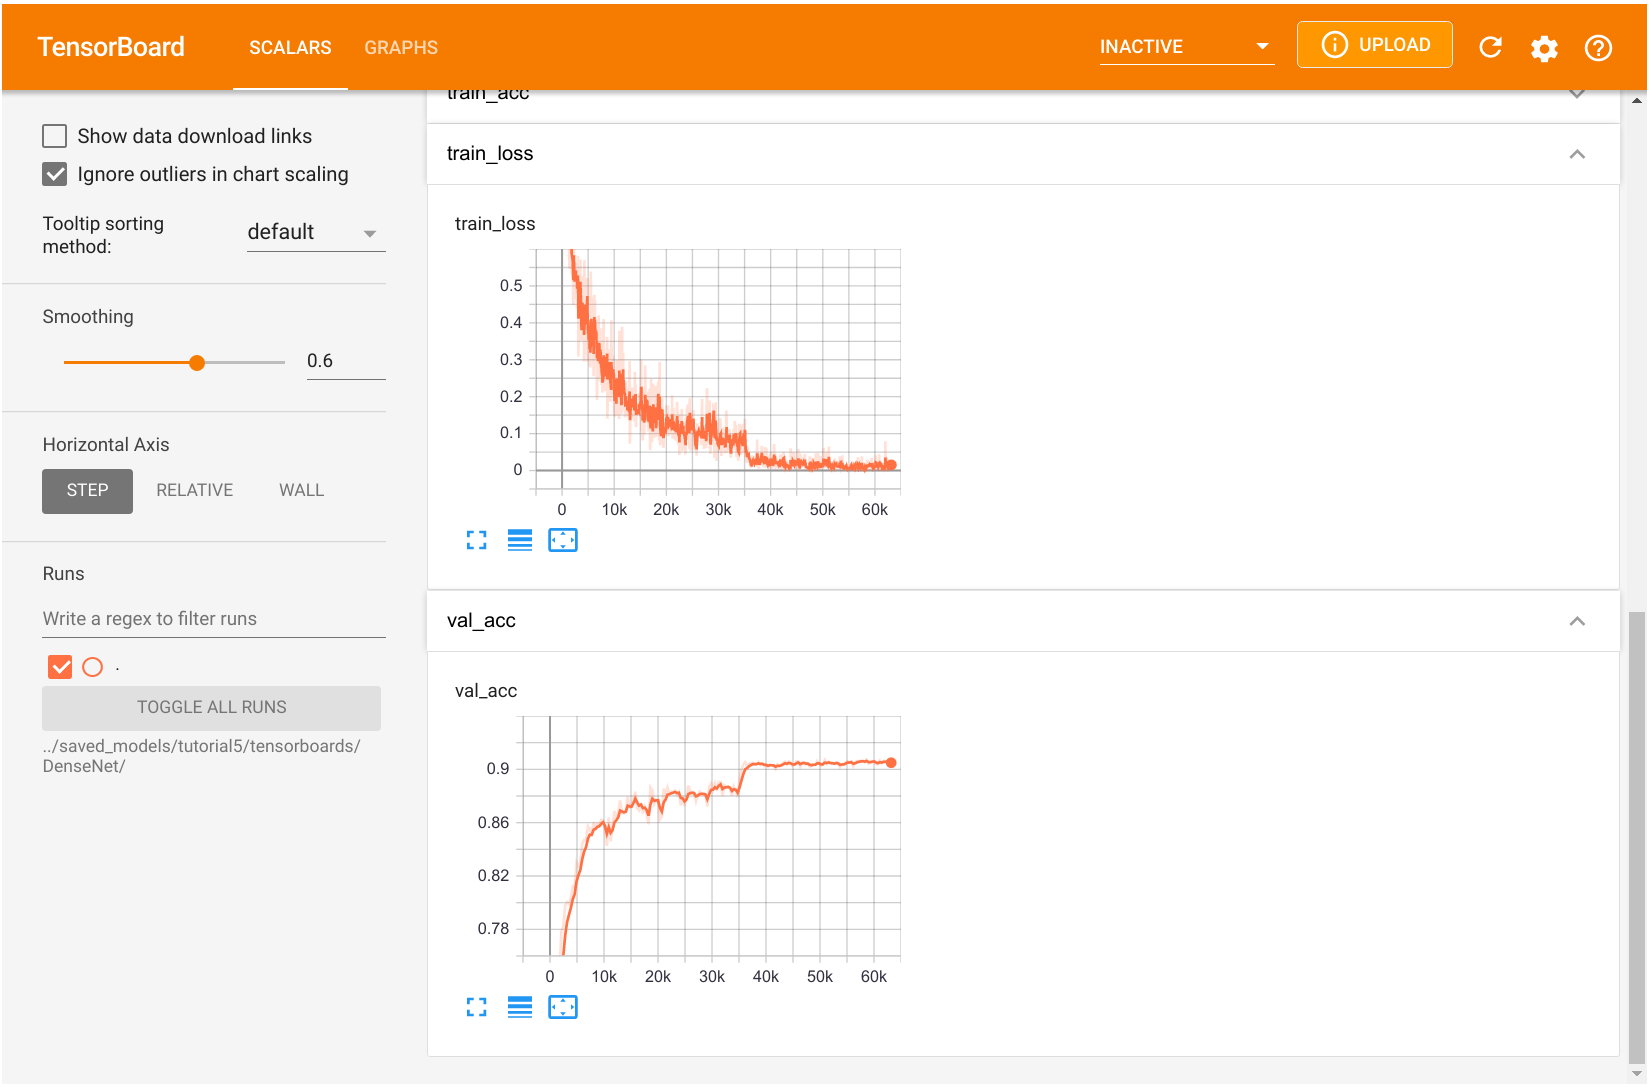

## Kesimpulan dan perbandingan

Setelah membahas setiap model secara terpisah, dan melatih semuanya, akhirnya kita dapat membandingkannya. Pertama, mari kita atur hasil semua model dalam sebuah tabel:

Mengatur style table html

In [44]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [45]:
import tabulate
from IPython.display import display, HTML
all_models = [
    ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    ("DenseNet", densenet_results, densenet_model)
]
table = [[model_name,
          f"{100.0*model_results['val']:4.2f}%",
          f"{100.0*model_results['test']:4.2f}%",
          "{:,}".format(sum([np.prod(p.shape) for p in model.parameters()]))]
         for model_name, model_results, model in all_models]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])))

Model,Val Accuracy,Test Accuracy,Num Parameters
GoogleNet,90.40%,89.70%,"260,650"
ResNet,91.84%,91.06%,"272,378"
ResNetPreAct,91.80%,91.07%,"272,250"
DenseNet,90.72%,90.23%,"239,146"


Pertama-tama, kita melihat bahwa semua model berkinerja cukup baik. 

GoogleNet merupakan model dengan performa terendah pada set validasi dan pengujian, meskipun sangat dekat dengan DenseNet. Pencarian hyperparameter yang tepat untuk semua ukuran channel di GoogleNet kemungkinan akan meningkatkan akurasi model ke tingkat yang sama, tetapi ini juga mempunyai komputasi yang mahal mengingat sejumlah besar hyperparameter. 

ResNet mengungguli DenseNet dan GoogleNet lebih dari 1% pada set validasi, sementara ada perbedaan kecil antara kedua versi, asli dan pra-aktivasi. Kita dapat menyimpulkan bahwa untuk jaringan dangkal, tempat fungsi aktivasi tampaknya tidak terlalu penting, meskipun makalah telah melaporkan sebaliknya untuk jaringan yang sangat dalam, misalnya [He et al](https://arxiv.org/abs/1603.05027).

Secara umum, kita dapat menyimpulkan bahwa ResNet adalah arsitektur yang sederhana namun kuat. Jika kita akan menerapkan model pada tugas yang lebih kompleks dengan gambar yang lebih besar dan lebih banyak layer di dalam jaringan, kemungkinan kita akan melihat kesenjangan yang lebih besar antara GoogleNet dan arsitektur skip-connection seperti ResNet dan DenseNet. Perbandingan dengan model yang lebih dalam di CIFAR10 misalnya dapat ditemukan [di sini](https://github.com/kuangliu/pytorch-cifar). Menariknya, DenseNet mengungguli ResNet asli pada setup tetapi berada di belakang ResNet Pra-Aktivasi. Model terbaik, Jaringan Dual Path ([Chen et. al](https://arxiv.org/abs/1707.01629)), sebenarnya merupakan kombinasi dari ResNet dan DenseNet yang menunjukkan bahwa keduanya menawarkan keuntungan yang berbeda.

### Model mana yang harus saya pilih untuk tugas saya?

Kita telah meninjau empat model yang berbeda. Jadi, mana yang harus kita pilih jika telah diberi tugas baru? Biasanya, memulai dengan ResNet adalah ide yang bagus mengingat performa yang unggul dari kumpulan data CIFAR dan implementasinya yang sederhana. Selain itu, untuk nomor parameter yang kita pilih di sini, ResNet adalah yang tercepat karena DenseNet dan GoogleNet memiliki lebih banyak layer yang diterapkan secara berurutan dalam implementasi primitif. Namun, jika kita memiliki tugas yang sangat sulit, seperti segmentasi semantik pada gambar HD, disarankan menggunakan varian ResNet dan DenseNet yang lebih kompleks.